# Game AB Testing

### Project Overview
This dataset was sourced from [Kaggle](https://www.kaggle.com/yufengsui/mobile-games-ab-testing) 
and contains player data from a popular mobile puzzle game. More details about the game can be 
found on the developer's [website](https://tactilegames.com/cookie-cats/).

In short, this project seeks to use A/B testing to explore the impact of a particular game 
mechanic on player retention / interaction. A random sampling of the overall playerbase will be 
pulled in to this case study: half serving as a test group to measure the outcome of a different 
progression system, and half as a control group to contrast with the above. The dataset will log 
"user interaction" as cumulative rounds played, and "frequency of play" as logins after 
pre-defined time intervals. Later statistical analysis of this data should yield a determination 
on the merit of this proposed game change.

### Data Exploration

In [1]:
# global imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from scipy import stats

In [2]:
# markdown print function
def printmd(text):
    display(Markdown(text))

In [3]:
# loading data
df = pd.read_csv('cookie_cats.csv')
print(df)

        userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3        False        False
1          337  gate_30              38         True        False
2          377  gate_40             165         True        False
3          483  gate_40               1        False        False
4          488  gate_40             179         True         True
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False

[90189 rows x 5 columns]


Columns descriptions:
  1. userid: integer, unique user identifier number
  2. version: string, player group name; gate_30 is the control group
  3. sum_gamerounds: integer, rounds played in week following install
  4. retention_1: bool, games played one day after install
  5. retention_7: bool, games played seven days after install

In [4]:
# column info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


90189 rows, each belonging to a unique user who installed the game during this test interval (one 
week). The dataset doesn't contain any null values, and all columns have reasonable data types.

In [5]:
# numerical stats
print(df.groupby('version').sum_gamerounds.describe())

           count       mean         std  min  25%   50%   75%      max
version                                                               
gate_30  44700.0  52.456264  256.716423  0.0  5.0  17.0  50.0  49854.0
gate_40  45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0   2640.0


Right away it is apparent that "sum_gamerounds" has at least one rather large outlier (and 
potentially others, though not quite as egregious); 75% of values lie between 0 and 51, yet the 
max value is 49854.

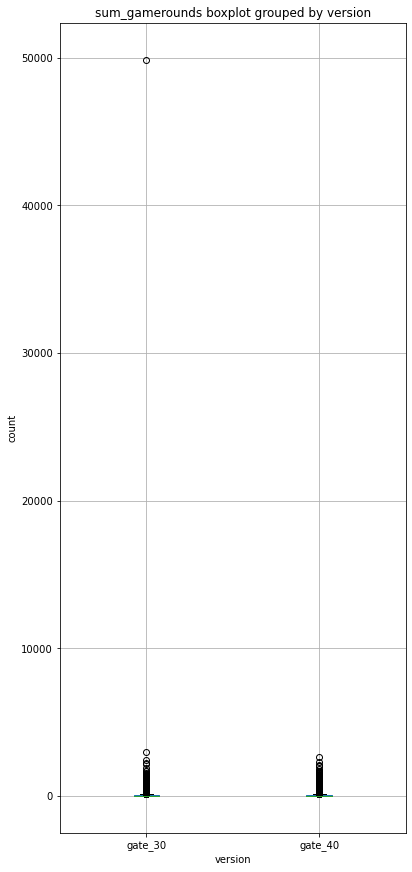

In [6]:
# visualizing outliers
fig, ax = plt.subplots()
fig.set_size_inches(6, 15)
df.boxplot(column = ['sum_gamerounds'], by = ['version'], ax = ax)
fig.suptitle('')
ax.set_title('sum_gamerounds boxplot grouped by version')
ax.set_xlabel('version')
ax.set_ylabel('count')
plt.show()

Dropping rows with "sum_gamerounds" greater than 10000 would remove this outlier and bring these 
box and whisker plots more in line, though this isn't necessary yet. The below is mostly just for 
visualization purposes.

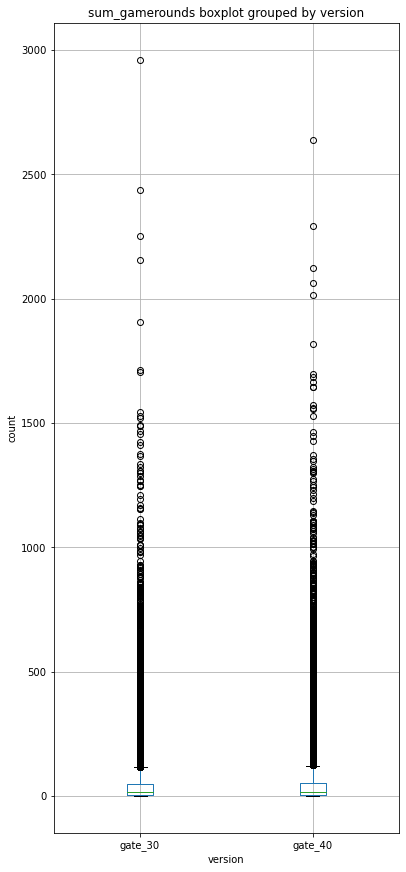

           count       mean         std  min  25%   50%   75%     max
version                                                              
gate_30  44699.0  51.342111  102.057598  0.0  5.0  17.0  50.0  2961.0
gate_40  45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0  2640.0


In [7]:
# outlier removal
df = df.query('sum_gamerounds < 10000')
fig, ax = plt.subplots()
fig.set_size_inches(6, 15)
df.boxplot(column = ['sum_gamerounds'], by = ['version'], ax = ax)
fig.suptitle('')
ax.set_title('sum_gamerounds boxplot grouped by version')
ax.set_xlabel('version')
ax.set_ylabel('count')
plt.show()
print(df.groupby('version').sum_gamerounds.describe())

There are still quite a few outliers (per the more standard 1.5*IQR rule), we may return to 
further reduce outliers pending analysis. Again, this step won't see usefulness until the 
"Categorical->Quantitative" hypothesis test.

In [8]:
# categorical stats
print(df.iloc[:, [1, 3, 4]].apply(pd.Series.value_counts))

         version  retention_1  retention_7
gate_40  45489.0          NaN          NaN
gate_30  44699.0          NaN          NaN
False        NaN      50035.0      73408.0
True         NaN      40153.0      16780.0


The two groups "gate_30" and "gate_40" split the entire dataset pretty much down the middle, 
though the same cannot be said for the boolean values of the two retention columns. 55% of 
new players did not return to play on day one, while an even greater percentage (81%) did not 
return on day seven. At a cursory glance, long term retention would be the more significant task 
to try to tackle.

In [9]:
# retention percentages
print(df.groupby('version')[['retention_1', 'retention_7']].mean())

         retention_1  retention_7
version                          
gate_30     0.448198     0.190183
gate_40     0.442283     0.182000


Day one and seven retention both look to average out to slightly higher values for "gate_30", 
approximate increases of .006 and .008 respectively, though keep in mind these numbers alone 
aren't enough to prove anything concretely. That said, the closeness of these between-group 
comparisons stresses that the impact from this A/B test is minimal.

In [10]:
# retention breakdown
retention_breakdown = df.groupby(['version', 'retention_1', 'retention_7']).userid.agg('count') \
    .groupby(level = 0).apply(lambda x: 100*x/float(x.sum()))
printmd('**Retention by boolean combination**')
print(retention_breakdown, '\n')
columns = ['gate_30 -> 40 deltas']
index = ['F-F', 'F-T', 'T-F', 'T-T']
retention_deltas = retention_breakdown[['gate_40']].values-retention_breakdown[['gate_30']].values
printmd('**Between group retention deltas**')
print(pd.DataFrame(retention_deltas, index = index, columns = columns))

**Retention by boolean combination**

version  retention_1  retention_7
gate_30  False        False          51.097340
                      True            4.082865
         True         False          29.884337
                      True           14.935457
gate_40  False        False          51.874079
                      True            3.897646
         True         False          29.925916
                      True           14.302359
Name: userid, dtype: float64 



**Between group retention deltas**

     gate_30 -> 40 deltas
F-F              0.776739
F-T             -0.185220
T-F              0.041579
T-T             -0.633098


A quick description of the four boolean combinations:

  1. F-F: no logins on days 1, 7; no retention
  2. F-T: login only on day 7; long term retention
  3. T-F: login only on day 1; short term retention
  4. T-T: logins on days 1, 7; overall retention

Depending on what type of retention we were seeking to improve (i.e. short, long term), 
our initial conclusion would be slightly different. Long term retention looks to generally have 
been negatively impacted in the "gate_40" group, while short term retention saw the opposite 
effect. Table 1 above displays percentages per boolean combo for each group, and table 2 the 
percentage delta going from "gate_30" to "gate_40". In plaintext english:

  1. +.78% failure to retain (F-F)
  2. -.19% long term retention (F-T)
  3. +.04% short term retention (T-F)
  4. -.63% overall retention (T-T)

### Hypothesis: Categorical->Categorical

Let:

  - H<sub>0</sub>: version does not impact retention (independent)
  - H<sub>a</sub>: version does impact retention (dependent)

This initial test will be looking at whether we can conclude, beyond a reasonable doubt, that 
there is a correlation between version and retention. Since our "version", "retention_1", and 
"retention_7" columns are categorical variables, a non-parametric test like chi2 fits our 
requirements best. A standard significance value of α = .05 will be used.

In [11]:
# retention counts
retention_counts = df.groupby(['version', 'retention_1', 'retention_7']).userid.count()
a = retention_counts['gate_30'].values
b = retention_counts['gate_40'].values
chi2, p, dof, ex = stats.chi2_contingency([a, b], correction = False)
printmd('**Results**')
print('Chi Statistic: {}\nP-value: {}\nDegrees of Freedom: {}'.format(chi2, p, dof))

**Results**

Chi Statistic: 10.776026093423667
P-value: 0.013000737455766848
Degrees of Freedom: 3


Our p-value is indeed smaller than our significance value, so our evidence points to a rejection 
of the null hypothesis; version and retention have a dependent relationship.

### Hypothesis: Categorical->Quantitative

Switching gears, we will next be looking at how the same categorical 
"version" independent variable impacts the discrete, quantitative 
"sum_gamerounds" dependent variable. I won't spend too much time on why I am 
going straight for a Wilcoxon Rank-Sum test, but the general gist is:

  1. dependent variable is not normally distributed
  2. power transform normalization unsuccessful

Whereas above we originally only removed the top outlier from our dataset (for boxplot 
visualization), this time around we are constraining our working data to the 1.5*IQR range per 
group.

Finally, let:

  - H<sub>0</sub>: the two samples come from the same population
  - H<sub>a</sub>: the two samples derive from different populations

In [12]:
# removing outliers
df = pd.read_csv('cookie_cats.csv')
old_shape = df.shape
for group in ['gate_30', 'gate_40']:
    q25, q75 = np.percentile(df.query('version == @group').sum_gamerounds, [25, 75], 
        interpolation = 'midpoint')
    iqr = q75 - q25
    q_hi = q75 + 1.5*iqr
    q_lo = q25 - 1.5*iqr
    df = df.query('(version != @group) or (version == @group and @q_lo < sum_gamerounds < @q_hi)')
df.reset_index(inplace = True, drop = True)
print(f'Old shape: {old_shape}\nNew shape: {df.shape}\nRows dropped: {old_shape[0] - df.shape[0]}')

Old shape: (90189, 5)
New shape: (79964, 5)
Rows dropped: 10225


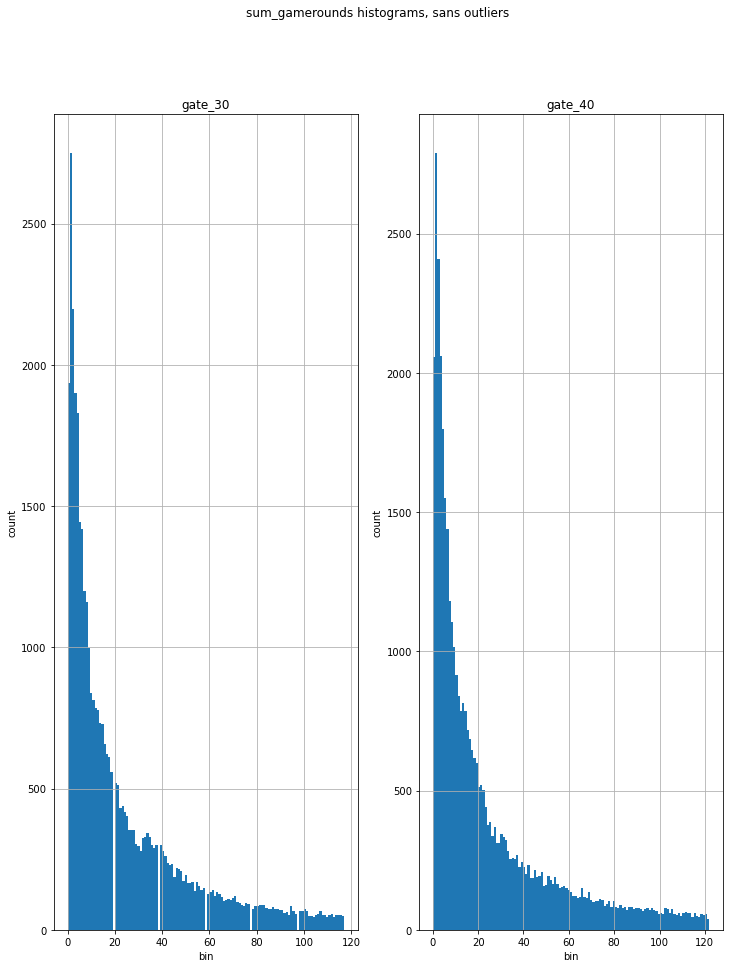

In [13]:
# distribution histogram
bins = df.sum_gamerounds.nunique()
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 15)
df[df.version == 'gate_30'].sum_gamerounds.hist(bins = bins, ax = ax1)
df[df.version == 'gate_40'].sum_gamerounds.hist(bins = bins, ax = ax2)
fig.suptitle('sum_gamerounds histograms, sans outliers')
ax1.set_title('gate_30')
ax1.set_xlabel('bin')
ax1.set_ylabel('count')
ax2.set_title('gate_40')
ax2.set_xlabel('bin')
ax2.set_ylabel('count')
plt.show()

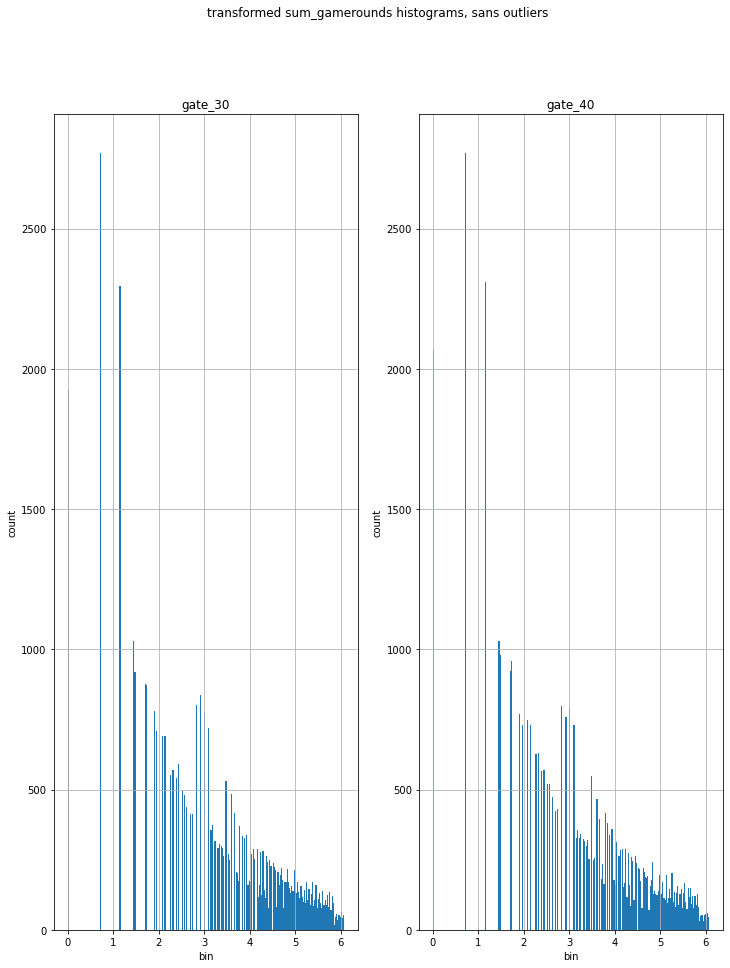

In [14]:
# power transform
df.sort_values(by = 'version', inplace = True)
temp = [stats.yeojohnson(df[df.version == g].sum_gamerounds)[0] for g in ['gate_30', 'gate_40']]
temp = np.atleast_2d(np.concatenate([*temp])).T
df_norm = pd.concat([df['version'], pd.DataFrame(temp, columns = ['sum_gamerounds'])], axis = 1)
bins = df_norm.sum_gamerounds.nunique()
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 15)
df_norm[df_norm.version == 'gate_30'].sum_gamerounds.hist(bins = bins, ax = ax1)
df_norm[df_norm.version == 'gate_40'].sum_gamerounds.hist(bins = bins, ax = ax2)
fig.suptitle('transformed sum_gamerounds histograms, sans outliers')
ax1.set_title('gate_30')
ax1.set_xlabel('bin')
ax1.set_ylabel('count')
ax2.set_title('gate_40')
ax2.set_xlabel('bin')
ax2.set_ylabel('count')
plt.show()

The post-transform histograms shown are no closer to a normal distribution than the 
pre-transform figures, hence the need for a non-parametric test (no assumptions on distribution 
characteristics). The same level / value of significance from above, α = .05, will be used below.

In [15]:
# wilcoxon rank sums
df.sort_index(inplace = True)
groups = ['gate_30', 'gate_40']
samples = [df[df.version == g].sum_gamerounds for g in groups]
output = stats.ranksums(*samples)
print('Test statistic: {}\nP-value: {}'.format(*output))

Test statistic: 0.5865496527240398
P-value: 0.5575062049083659


In contrast to the prior hypothesis test, this particular p-value fails to reject the null 
hypothesis. Stated another way, we don't have enough evidence to suggest the two "sum_gamerounds" 
distributions come from different populations.

### Concluding Thoughts

This notebook is looking at two different aspects of this dataset, but is ultimately using the 
same methodology to evaluate independent-dependent variable relationships. In both instances, A/B 
testing is observing the change in outcome based on change in input. The first round is testing a 
categorical to categorical (user group to retention type) relationship, while the second 
categorical to quantitative (user group to interaction count). In both scenarios non-parametric 
tests are utilized, but for slightly different reasons: chi2 is one of few tests that deals 
well with categorical input and output, and Wilcoxon Rank Sums (Mann-Whitney U) categorical 
input and non-normal quantitative output.

Hypothesis test 1 concludes that there is enough evidence to reject the null hypothesis, or that 
there is an association between the two categorical variables under analysis. Later inspection 
highlights a loss in overall retention (-.78%) when comparing the test and control groups. 
Hypothesis test 2, on the other hand, accepts the null hypothesis that the two sample 
distributions are equal. This suggests that the varying of users and groups has no statistically 
significant impact on games played in a week.

As for the business implications of this A/B test, absent of any supplemental data covering user 
purchasing patterns and advertisement viewership, the conclusion would be that the newly tested 
progression system has a net negative impact on overall user retention and therefore should not 
see a wider rollout.